# JB resellers research

### Common preparations

In [1]:
%matplotlib inline

from sklearn.linear_model.base import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing.data import StandardScaler, PolynomialFeatures
from sklearn.svm import OneClassSVM
from sklearn.cross_validation import cross_val_predict
from sklearn import cross_validation
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm.classes import SVR

import data_preprocess
import metadata
import logging
from clusterization_model import ClusterizationModel
from sklearn import preprocessing as preproc

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

# reload(logging)
logging.basicConfig(format='%(levelname)s %(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


def remove_columns(df, columns):
    new_columns = list(filter(lambda x: x not in columns, df.columns))
    return df[new_columns]


def get_columns(df, columns, get_all_match=True):
    new_columns = []
    for column in columns:
        all_match = list(filter(lambda x: column in x, df.columns))
        if get_all_match or column not in df.columns:
            new_columns += all_match
        else:
            new_columns.append(column)
    return new_columns


def plot_statistic(statistic, title, names=None, conf_interv=None):
    fig, ax = plt.subplots()
    index = np.arange(len(statistic))
    plt.bar(index, statistic, yerr=conf_interv, color='b', alpha=0.7)
    if names is not None:
        plt.xticks(index + 0.4, names)
    # plt.xlabel("Stocks")
    plt.ylabel(title)
    plt.show()

def remove_outliers(data):
    clf = OneClassSVM(nu=0.2, kernel="rbf", gamma=0.00001)
    clf.fit(data)
    logging.info("%s outliers removed from %s elements" % ((clf.predict(data) == -1).sum(), len(data)))
    return data[clf.predict(data) == 1]


### Load previusly preprocessed data

In [2]:
data = data_preprocess.get_data()

X = data.main_data_frame

### Make clients clustering

                 customer_id   loyalty  Products number  USD_total  \
customer_id         1.000000 -0.244625        -0.265155  -0.250018   
loyalty            -0.244625  1.000000         0.818613   0.948336   
Products number    -0.265155  0.818613         1.000000   0.912153   
USD_total          -0.250018  0.948336         0.912153   1.000000   
Renew loyalty      -0.217626  0.410939         0.406621   0.473808   
Sale part           0.102762  0.056035        -0.027882   0.030869   
GDP                -0.164432  0.152866         0.205546   0.154926   
HDI                -0.136632  0.099809         0.110882   0.107454   
population         -0.060084  0.063892         0.090878   0.053517   
urban              -0.098238  0.084007         0.121910   0.111295   
avg_income         -0.204288  0.153261         0.188577   0.159752   

                 Renew loyalty  Sale part       GDP       HDI  population  \
customer_id          -0.217626   0.102762 -0.164432 -0.136632   -0.060084   
loyal

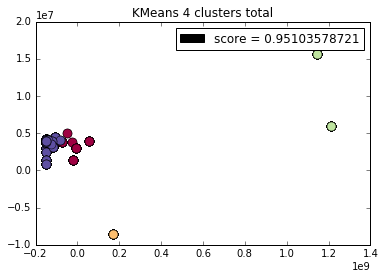

In [7]:
def clients_clusterization(X):
    clients_df = X[get_columns(X, ['stock_id', 'customer_id', 'quantity', 'customer_status', 'license_type', 'iso',
                                   'amount_in_usd', 'GDP', 'HDI', 'population', 'urban', 'avg_income',
                                   'discount_perc'])]
    clients_df.reset_index(inplace=True)

    clients_loyalty = clients_df.groupby('customer_id')[['customer_id']].mean()
    clients_loyalty['loyalty'] = 0
    clients_loyalty['Renew loyalty'] = 0
    del clients_loyalty['customer_id']
    stock_quantity_columns = []
    for stock_id in metadata.stock_ids:
        stock_name = metadata.stock_ids[stock_id][0]
        if stock_name == "None":
            continue
        add_N = clients_df[clients_df['stock_id'] == stock_id].groupby('customer_id')['quantity'].sum()
        add_Renew = clients_df[(clients_df['stock_id'] == stock_id) &
                               (clients_df['license_type'] == 2)].groupby('customer_id')['quantity'].count()
        if len(add_N) == 0:
            continue
        col_name = stock_name + '_quantity'
        stock_quantity_columns.append(col_name)
        add_N_df = add_N.to_frame(col_name)
        clients_loyalty = pd.merge(clients_loyalty, add_N_df, how='left', left_index=True, right_index=True)
        clients_loyalty[col_name] = np.nan_to_num(clients_loyalty[col_name])

        add_N2 = add_N * add_N
        add_N2_df = add_N2.to_frame('loyalty')
        add_Renew2 = add_Renew * add_Renew
        add_Renew2_df = add_Renew2.to_frame('Renew loyalty')
        clients_loyalty = pd.merge(clients_loyalty, add_N2_df, how='left', left_index=True, right_index=True)
        clients_loyalty['loyalty'] = clients_loyalty['loyalty_x'] + np.nan_to_num(clients_loyalty['loyalty_y'])
        clients_loyalty = pd.merge(clients_loyalty, add_Renew2_df, how='left', left_index=True, right_index=True)
        clients_loyalty['Renew loyalty'] = clients_loyalty['Renew loyalty_x'] + np.nan_to_num(
            clients_loyalty['Renew loyalty_y'])
        del clients_loyalty['loyalty_x']
        del clients_loyalty['loyalty_y']
        del clients_loyalty['Renew loyalty_x']
        del clients_loyalty['Renew loyalty_y']

    clients_loyalty['loyalty'] **= 0.5
    clients_loyalty['Renew loyalty'] **= 0.5

    clients_df = pd.merge(clients_df, clients_loyalty, how='left', left_on='customer_id', right_index=True)

    def calc_feature(df_from, df_to, base_param_name, new_param_name, group_id='customer_id'):
        df_from = df_from.groupby(group_id).sum().reset_index()
        df_from[new_param_name] = df_from[base_param_name]
        result = pd.merge(df_to, df_from[[group_id, new_param_name]], how='left', on=group_id)
        result[new_param_name] = np.nan_to_num(result[new_param_name])
        return result

    clients_new_pursh = clients_df[['customer_id', 'quantity', 'license_type']].loc[clients_df['license_type'] == 0]
    clients_df = calc_feature(clients_new_pursh, clients_df, 'quantity', 'Products number')

    clients_df = calc_feature(clients_df[['customer_id', 'amount_in_usd']], clients_df, 'amount_in_usd', 'USD_total')

    clients_sale_filtered = clients_df[['customer_id', 'amount_in_usd']][clients_df['discount_perc'] > 10]
    clients_df = calc_feature(clients_sale_filtered, clients_df, 'amount_in_usd', 'Dicsount_amount_USD')

    clients_df['Sale part'] = clients_df['Dicsount_amount_USD'] / clients_df['USD_total']

    old_columns = ['GDP', 'HDI', 'population', 'urban', 'avg_income']
    chosen_columns = ['customer_id', 'loyalty', 'Products number', 'USD_total', 'Renew loyalty',
                      'Sale part'] + old_columns  # + stock_quantity_columns
    clients_df = clients_df[chosen_columns]
    print(clients_df.corr())

    clients_df = clients_df.groupby('customer_id').mean().reset_index()
    # drop few outliers, which have been found by hierarchy clusterization
    drop_index = clients_df['customer_id'].apply(
        lambda x: x not in [10402, 10518, 3513, 3795, 5632, 6372, 8325, 1031, 3384,
                            5586, 6308, 8249, 10100, 2857, 5555, 6265, 8183, 10009, 2850, 907, 1006, 37, 904])
    clients_df = clients_df.drop(drop_index)

    columns_without_id = list(clients_df.columns)
    columns_without_id.remove('customer_id')
    clients = clients_df[columns_without_id]

    n_clusters = 4
    # f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    # clustering_model = ClusterizationModel(model="agglomerative").fit(clients)
    # clustering_model.draw_clusters(method="", axis=ax1, show=False)
    # clustering_model = ClusterizationModel(model="dbscan", eps=5e4, min_samples=1).fit(clients)
    # clustering_model.draw_clusters(method="", axis=ax2, show=False)
    clustering_model = ClusterizationModel(n_clusters=n_clusters, model="KMeans").fit(clients)
    clustering_model.draw_clusters(method="", show=True)
    # clustering_model = ClusterizationModel(model="hierarchy").fit(clients)
    # clustering_model.draw_clusters(method="dendrogram", show=True)

    mean_values = clustering_model.get_mean_values()
    mean_values = mean_values.sort_values(by='loyalty', ascending=[1])

    labels = clustering_model.get_labels()
    clients_df['label'] = pd.Series(labels)
    return mean_values, clients_df


mean_values, clients_df = clients_clusterization(X)

In [8]:
print(mean_values)

         loyalty  Products number    USD_total  Renew loyalty  Sale part  \
label                                                                      
0.0    12.021740         9.271012  3964.304048       0.386954   0.627681   
3.0    15.051284        10.616257  4855.049442       0.343694   0.602911   
2.0    15.396569        14.309859  5172.476592       0.276950   0.619626   
1.0    20.451010        14.460036  6742.779991       0.469242   0.546929   

                GDP       HDI    population     urban   avg_income  \
label                                                                
0.0    6.007887e+06  0.883329  1.413004e+08  0.772967  2216.888508   
3.0    6.143952e+06  0.883033  1.469467e+08  0.771202  2220.788658   
2.0    6.624161e+06  0.876186  1.960453e+08  0.762930  2177.698592   
1.0    7.130290e+06  0.889033  1.540095e+08  0.780027  2371.243869   

       Cluster size  
label                
0.0             583  
3.0            5290  
2.0             355  
1.0         

### Make resellers clustering

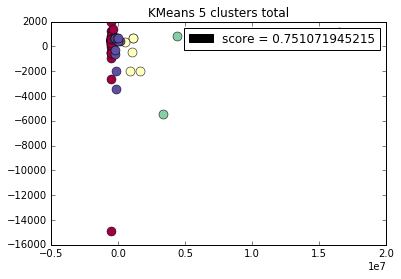

In [18]:
resellers_df = X[['reseller_id', 'reseller_volume', 'reseller_discount', 'amount_in_usd', 'customer_id']]
clusters_labels = list(clients_df['label'].unique())
clients_labels = clients_df[['customer_id', 'label']]
clients_labels.columns = ['customer_id', 'client_label']
resellers_grouped_df_mean = resellers_df.groupby('reseller_id').mean().reset_index()
resellers_df = pd.merge(resellers_df, clients_labels, on='customer_id')
resellers_df = data_preprocess.preprocess_categorical(resellers_df, ['client_label'])

clients_labels_full = list(filter(lambda x: 'client_label' in x, resellers_df.columns))
resellers_grouped_df_sum = resellers_df[['reseller_id', 'amount_in_usd'] + clients_labels_full].groupby(
    'reseller_id').sum().reset_index()
resellers_grouped_df = pd.merge(resellers_grouped_df_mean, resellers_grouped_df_sum, on='reseller_id')

resellers_grouped_clean_df = remove_columns(resellers_grouped_df, ['reseller_id', 'customer_id'])
n_clusters = 5
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
# cluster_reseller_model = ClusterizationModel(model="agglomerative").fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="", axis=ax1, show=False)
# cluster_reseller_model = ClusterizationModel(model="dbscan", eps=5e4, min_samples=1).fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="", axis=ax2, show=False)
cluster_reseller_model = ClusterizationModel(n_clusters=n_clusters, model="KMeans").fit(resellers_grouped_clean_df)
cluster_reseller_model.draw_clusters(method="", show=True)
# cluster_reseller_model = ClusterizationModel(model="hierarchy").fit(resellers_grouped_clean_df)
# cluster_reseller_model.draw_clusters(method="dendrogram", show=True)

resellers_grouped_df['reseller_cluster'] = pd.Series(cluster_reseller_model.get_labels())
X = pd.merge(X, resellers_grouped_df[['reseller_id', 'reseller_cluster'] + clients_labels_full], how='left',
             on='reseller_id')
X = data_preprocess.preprocess_categorical(X, ['reseller_cluster'])

In [19]:
print(cluster_reseller_model.get_mean_values())

       reseller_volume  reseller_discount  amount_in_usd_x  amount_in_usd_y  \
label                                                                         
0           561.185185           6.759259      1917.669746     5.214171e+04   
1           486.000000           5.000000      1167.395934     1.708138e+07   
2          1077.166667          10.833333      1070.081344     1.609568e+06   
3          3119.500000          10.000000      1043.308936     4.404877e+06   
4           679.733333           8.000000      1989.065382     4.209978e+05   

       client_label  client_label_0  client_label_1  client_label_2  \
label                                                                 
0         82.925926        2.277778       12.500000        1.462963   
1      31553.000000      783.000000     4789.000000      416.000000   
2       3462.166667       82.500000      502.000000       72.500000   
3       8730.500000      256.500000     1458.500000      213.000000   
4        635.533333 

In [20]:
print(resellers_grouped_clean_df.corr())

                   reseller_volume  reseller_discount  amount_in_usd_x  \
reseller_volume           1.000000           0.295364        -0.038978   
reseller_discount         0.295364           1.000000         0.206650   
amount_in_usd_x          -0.038978           0.206650         1.000000   
amount_in_usd_y           0.054914           0.006525        -0.087855   
client_label              0.070388           0.039711        -0.110505   
client_label_0            0.055739           0.036851        -0.111252   
client_label_1            0.070985           0.016621        -0.107016   
client_label_2            0.157671           0.168859        -0.128027   
client_label_3            0.066563           0.038849        -0.109967   
client_label_4            0.020167          -0.052264        -0.051482   
label                     0.073915           0.142341        -0.023632   

                   amount_in_usd_y  client_label  client_label_0  \
reseller_volume           0.054914      0.0

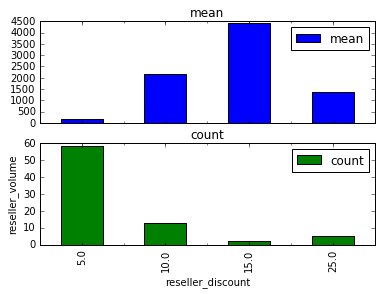

In [24]:
# plot resellers volume, grouped by discount
discount_groups = resellers_grouped_df[['reseller_volume', 'reseller_discount']].groupby('reseller_discount').agg(
    ['mean', 'count'])
discount_groups['reseller_volume'].plot(kind='bar', subplots=True)
plt.ylabel('reseller_volume')
plt.show()
# Note: 'resellers_volume' axis name displayed a bit wrong - it should be near upper axis

In [25]:
# pd.tools.plotting.scatter_matrix(clients, alpha=0.2,
#                                  c='red', hist_kwds={'color': ['burlywood']})
# plt.show()

In [30]:
iso_features = get_columns(X, ["region="])
resellers_regions_df = X[['reseller_cluster'] + iso_features]
resellers_regions_df = resellers_regions_df.groupby('reseller_cluster').sum()

In [31]:
resellers_regions_df.head()

,region=Asia,region=Australia,region=Eastern Europe,region=Near East,region=North America,region=Russia,region=South Africa,region=Western Europe
reseller_cluster,,,,,,,,
0,121.0,292.0,1123.0,67.0,0.0,225.0,2.0,262.0
1,17.0,0.0,13565.0,10.0,1007.0,0.0,33.0,1.0
2,413.0,749.0,7466.0,337.0,2.0,9.0,0.0,596.0
3,29.0,1.0,8112.0,70.0,0.0,1.0,0.0,207.0
4,642.0,0.0,1193.0,1370.0,6.0,724.0,0.0,611.0


### License quantity prediction

In [32]:
X = X.set_index(X['placed_date'])
X = X.sort_index()

stock_ids = list(filter(lambda stock_id: metadata.stock_ids[stock_id][0] != 'None', X["stock_id"].unique()))
stock_ids = list(filter(lambda stock_id: len(X[X["stock_id"] == stock_id]) >= 10, stock_ids))

short_names = {v: k for k, v in metadata.stock_short_name_ids.items()}
stock_names = list(map(lambda st_id: metadata.stock_ids[st_id][0], stock_ids))

stock_rows = X

techs = metadata.tech_ids.values()

predictors = get_columns(X, ['discount_desc', 'customer_status', 'license_type', 'reseller_discount',
                             'reseller_volume', 'urban', 'population', 'HDI', 'avg_income', 'GDP', 'client_label',
                             'reseller_cluster'])
# leave only derivative features: 'license_type_0', 'license_type_1' etc.
predictors.remove('license_type')
predictors.remove('reseller_cluster')

x = stock_rows[predictors]
from math import ceil

mean_quantity = ceil(stock_rows['quantity'].mean())
print("mean: %s" % mean_quantity)


def quantity_mapper(quantity):
    if quantity <= 1.1:
        return 0
    if quantity <= mean_quantity + 0.1:
        return 1
    return 2


response = "QuantityClass"
stock_rows[response] = stock_rows['quantity'].apply(quantity_mapper)

y = stock_rows[response]


def remove_if_constant(df, column):
    if df[column].isin(df[column].iloc[:1]).all():
        del df[column]


for column in x.columns:
    remove_if_constant(x, column)

folds_cnt = 10
if len(x) < 20:
    folds_cnt = 2

# also I've been trying Logistic/LinearRegression, RandomForestClassifier/Regressor, Ada/GradientBoostingRegressor
# in addition with polynomial features
# but obtained results were either worse, or slightly better (not significant)
model = tree.DecisionTreeRegressor(max_features=10, random_state=0, max_depth=3,
                                   max_leaf_nodes=5)
predicted = cross_val_predict(model, x, y, cv=folds_cnt, n_jobs=4)

predicted = predicted.round()

scores = cross_validation.cross_val_score(model, x, y, cv=folds_cnt, n_jobs=4)
model = model.fit(x, y)

mean: 5.0


#### Draw the DecisionTree in GraphViz file

In [33]:
from sklearn.externals.six import StringIO
import pydot

from IPython.display import Image
f = open("tree.dot", "w")
tree.export_graphviz(model, out_file=f,
                     feature_names=predictors)
f.close()
# graph = pydot.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

Couldn't import dot_parser, loading of dot files will not be possible.


In [34]:
feature_importances = sorted(zip(model.feature_importances_, predictors), reverse=True)
print("\n".join(map(lambda x: "%17s: %s" % (x[1], str(x[0])), (filter(lambda x: x[0] > 0, feature_importances)))))

   license_type_0: 0.653732163161
   client_label_3: 0.137795855716
reseller_discount: 0.123980172783
customer_status_0: 0.0844918083399


In [35]:
print("r2: %s" % scores.mean())

r2: 0.0551830197526


In [36]:
mse = metrics.mean_squared_error(y, predicted)
print("mse: %s " % mse)

mse: 0.711662379339 


In [18]:
# residuals_df = pd.DataFrame([])
# residuals_df["value"] = abs(y - predicted)
# residuals_df = residuals_df.sort_values(by='value')
# plot_statistic(residuals_df["value"], "Residuals")

### Predict reseller purshase (time series prediction)

In [37]:
import statsmodels.api as sm
from scipy import stats
import pyflux as pf

def estimate_garch(time_series_df):
    import sys
    def run_garch(garch):
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        garch.fit()
        sys.stdout = old_stdout
        arr = mystdout.getvalue().split('\n')
        Likelihood = AIC = BIC = None
        for s in arr:
            if "Log" in s:
                Likelihood = float(s.split(':')[1])
            if "AIC" in s:
                AIC = float(s.split(':')[1])
            if "BIC" in s:
                BIC = float(s.split(':')[1])
        return Likelihood, AIC, BIC

    best = {'AIC': 99999,
            'BIC': 99999,
            'Log':-99999,
            'GARCH': None
           }
    for p in range(2,20,2):
        q = p - 1
        print("%s %s" % (p,q))
        garch = pf.EGARCH(time_series_df,p=p,q=q)
        l, aic, bic = run_garch(garch)
        if l > best["Log"]:
            best["AIC"] = aic
            best["BIC"] = bic
            best["Log"] = l
            best["GARCH"] = garch
    best['GARCH'].plot_fit(figsize=(15,5))
    return best

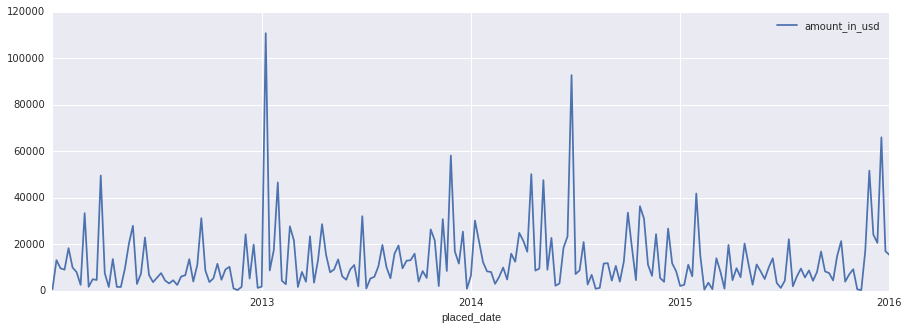

3 2
amount_in_usd picked as target variable

5 4
amount_in_usd picked as target variable

7 6
amount_in_usd picked as target variable

9 8
amount_in_usd picked as target variable

11 10
amount_in_usd picked as target variable

13 12
amount_in_usd picked as target variable

15 14
amount_in_usd picked as target variable

17 16
amount_in_usd picked as target variable

19 18
amount_in_usd picked as target variable



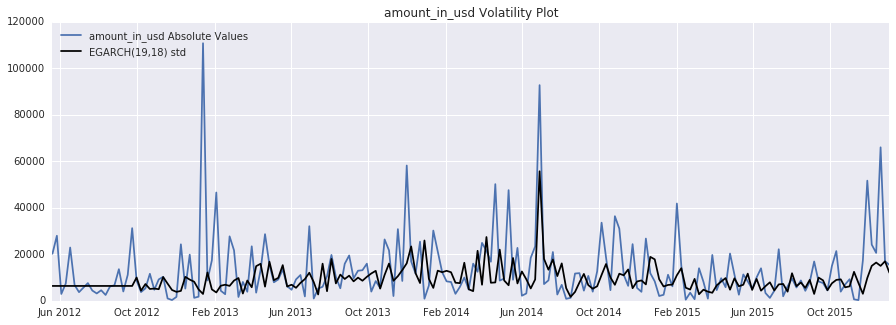

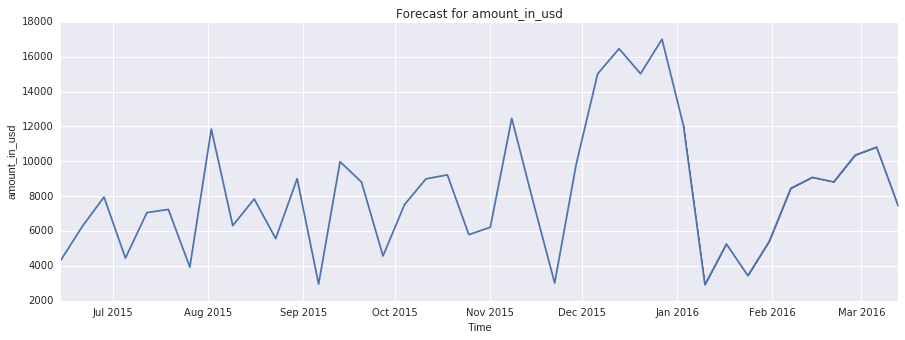

             amount_in_usd
placed_date               
2016-01-10     2922.681860
2016-01-17     5257.523319
2016-01-24     3442.013111
2016-01-31     5416.412917
2016-02-07     8447.777662
2016-02-14     9079.463459
2016-02-21     8818.290535
2016-02-28    10353.435469
2016-03-06    10814.566297
2016-03-13     7457.161178


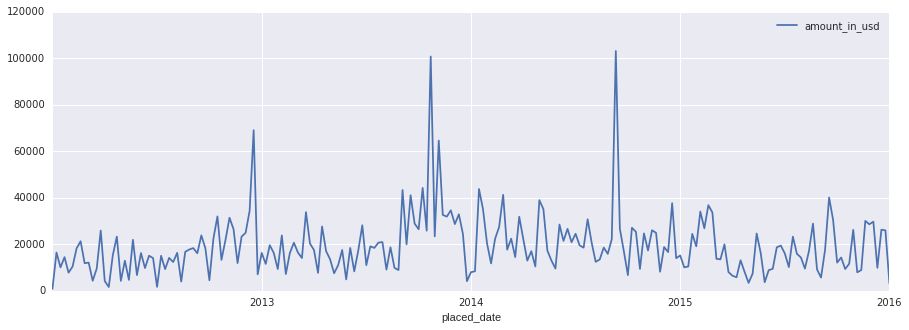

3 2
amount_in_usd picked as target variable

5 4
amount_in_usd picked as target variable

7 6
amount_in_usd picked as target variable

9 8
amount_in_usd picked as target variable

11 10
amount_in_usd picked as target variable

13 12
amount_in_usd picked as target variable

15 14
amount_in_usd picked as target variable

17 16
amount_in_usd picked as target variable

19 18
amount_in_usd picked as target variable



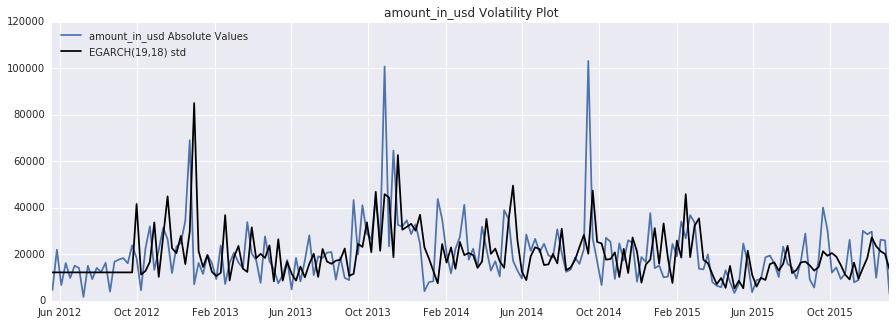

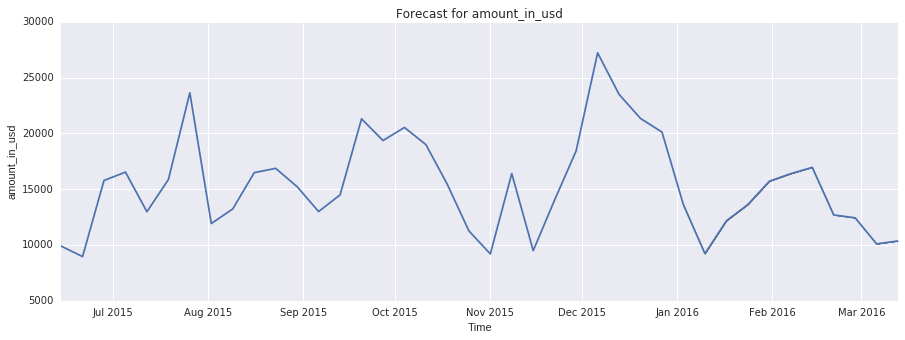

             amount_in_usd
placed_date               
2016-01-10     9227.659501
2016-01-17    12165.220533
2016-01-24    13623.303198
2016-01-31    15711.183373
2016-02-07    16391.166590
2016-02-14    16957.435879
2016-02-21    12693.482711
2016-02-28    12434.022136
2016-03-06    10098.280591
2016-03-13    10364.091570


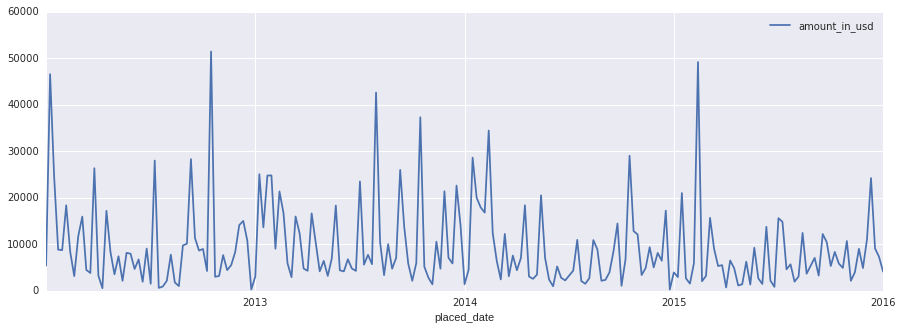

3 2
amount_in_usd picked as target variable

5 4
amount_in_usd picked as target variable

7 6
amount_in_usd picked as target variable

9 8
amount_in_usd picked as target variable

11 10
amount_in_usd picked as target variable

13 12
amount_in_usd picked as target variable

15 14
amount_in_usd picked as target variable

17 16
amount_in_usd picked as target variable

19 18
amount_in_usd picked as target variable



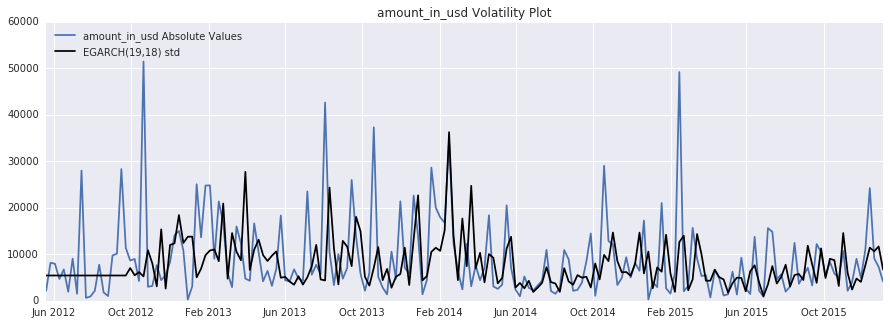

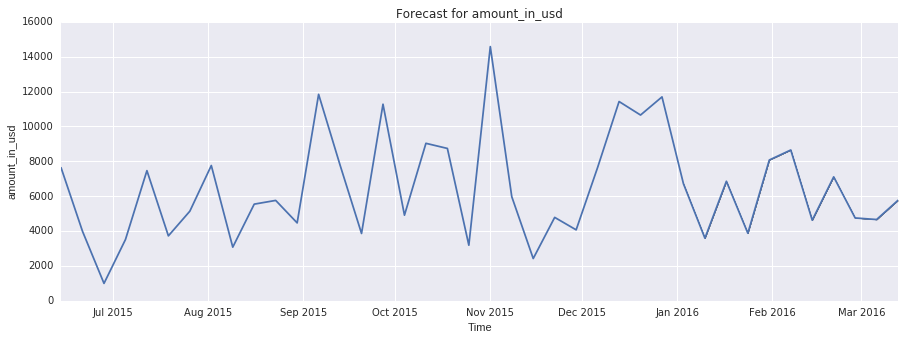

             amount_in_usd
placed_date               
2016-01-10     3589.157749
2016-01-17     6854.708012
2016-01-24     3874.714781
2016-01-31     8074.338116
2016-02-07     8647.976986
2016-02-14     4622.596799
2016-02-21     7106.950579
2016-02-28     4750.511134
2016-03-06     4661.258982
2016-03-13     5767.175446


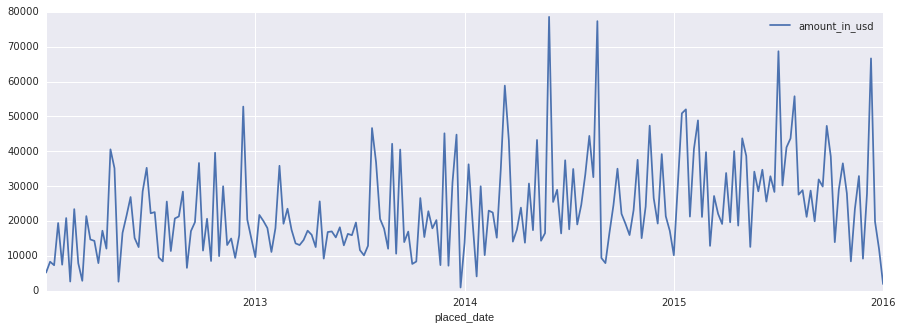

3 2
amount_in_usd picked as target variable

5 4
amount_in_usd picked as target variable

7 6
amount_in_usd picked as target variable

9 8
amount_in_usd picked as target variable

11 10
amount_in_usd picked as target variable

13 12
amount_in_usd picked as target variable

15 14
amount_in_usd picked as target variable

17 16
amount_in_usd picked as target variable

19 18
amount_in_usd picked as target variable



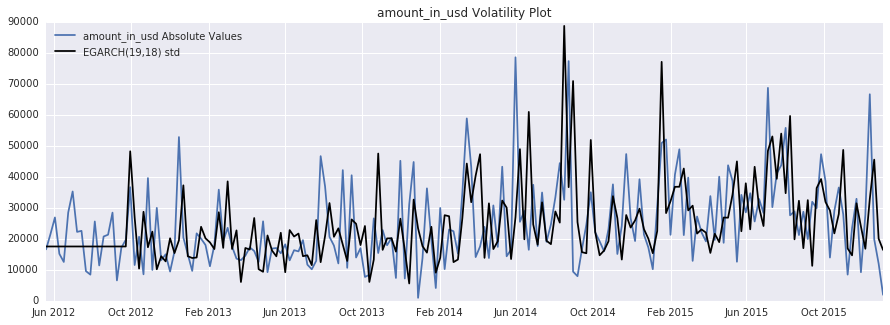

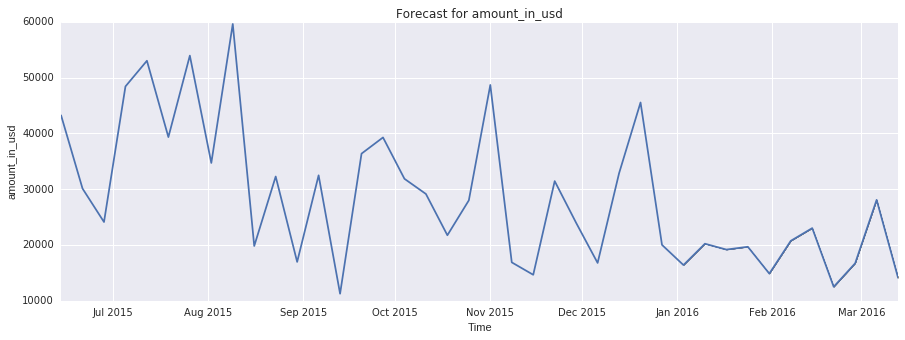

             amount_in_usd
placed_date               
2016-01-10    20230.685869
2016-01-17    19180.224992
2016-01-24    19681.170583
2016-01-31    14872.481411
2016-02-07    20745.878615
2016-02-14    23026.236455
2016-02-21    12510.590291
2016-02-28    16725.463077
2016-03-06    28088.596625
2016-03-13    14116.852445


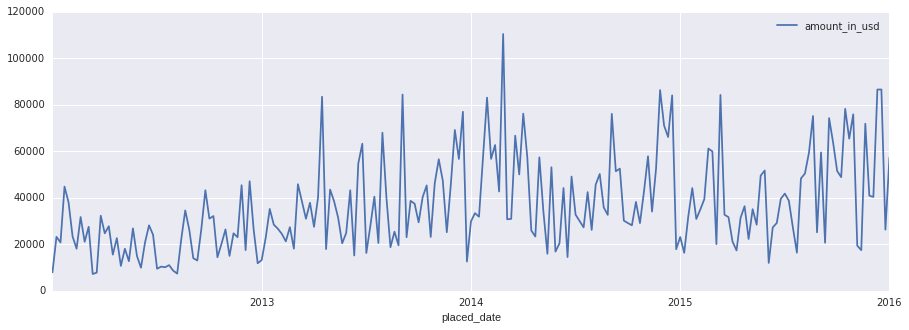

3 2
amount_in_usd picked as target variable

5 4
amount_in_usd picked as target variable

7 6
amount_in_usd picked as target variable

9 8
amount_in_usd picked as target variable

11 10
amount_in_usd picked as target variable

13 12
amount_in_usd picked as target variable

15 14
amount_in_usd picked as target variable

17 16
amount_in_usd picked as target variable

19 18
amount_in_usd picked as target variable



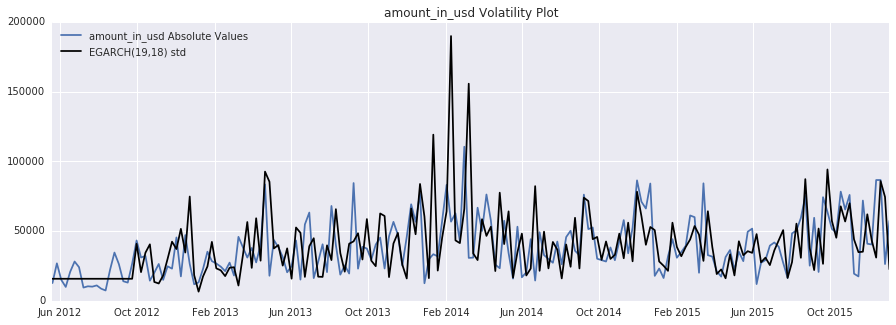

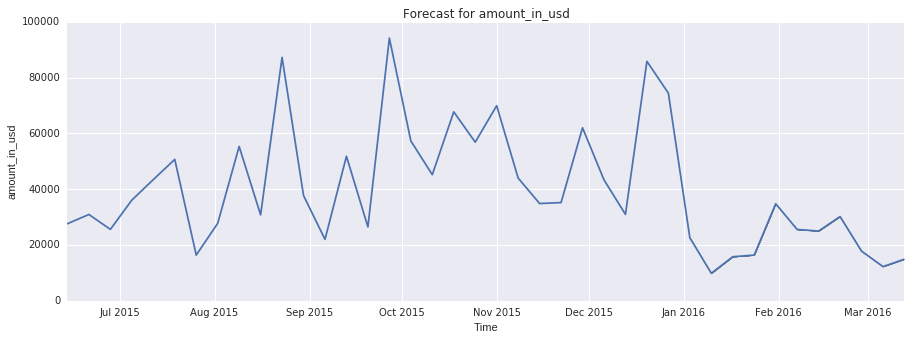

             amount_in_usd
placed_date               
2016-01-10     9861.769467
2016-01-17    15790.675359
2016-01-24    16385.395867
2016-01-31    34791.111546
2016-02-07    25570.650225
2016-02-14    24992.215557
2016-02-21    30199.717207
2016-02-28    17805.852949
2016-03-06    12255.878234
2016-03-13    14929.434473


In [21]:
reseller_clusters = list(X['reseller_cluster'].unique())
for cluster in reseller_clusters:
    print("cluster: %s" % cluster)
    resellers_df = X[['reseller_cluster', 'amount_in_usd', 'placed_date']][X['reseller_cluster'] == cluster]
    resellers_df['placed_date'] = pd.to_datetime(resellers_df['placed_date'])
    resellers_df = resellers_df[(resellers_df['placed_date'] >= '2012-01-01') & (resellers_df['placed_date'] < '2016-01-01')]
    resellers_df = resellers_df.set_index(resellers_df['placed_date'])
    resellers_df = resellers_df.sort_index()
    resellers_df = resellers_df[['amount_in_usd']]
    resellers_df = resellers_df.groupby(pd.TimeGrouper(freq='W')).sum()
    resellers_df['amount_in_usd'].interpolate(method="values", inplace=True)
    time_series_df = pd.DataFrame(resellers_df[['amount_in_usd']])
    time_series_df.plot(figsize=(15,5))
    plt.show()
    res = estimate_garch(time_series_df)
    garch = res['GARCH']
    garch.plot_predict(h=10,past_values=30,figsize=(15,5))
    print(garch.predict(h=10))